In [5]:
import pandas as pd 
import matplotlib.pyplot as plt
import yfinance as yf
import numpy as np

from scipy.stats import norm
from matplotlib.ticker import PercentFormatter
import scipy.stats
import datetime as dt

# Part 1: Basic Analysis of Bitcoin's historical performance

### Simple Descriptive Statistics, Annualized Returns, Volatility, and Normality Check

In [6]:
# We create the Ticker object for BTC-USD and then import the time-series using the module yfinance
btc = yf.Ticker("BTC-USD")
btc_hist = btc.history(period = "10y")

btc_close = btc_hist["Close"]

In [7]:
btc_close.head()

Date
2015-01-24 00:00:00+00:00    247.847000
2015-01-25 00:00:00+00:00    253.718002
2015-01-26 00:00:00+00:00    273.472992
2015-01-27 00:00:00+00:00    263.475006
2015-01-28 00:00:00+00:00    233.914993
Name: Close, dtype: float64

In [8]:
# Some descriptive statistics
btc_close.describe().iloc[1:]

mean     20787.633293
std      23039.394007
min        210.494995
25%       2804.952515
50%       9815.709961
75%      33840.999023
max     106146.265625
Name: Close, dtype: float64

In [9]:
btc_returns_10y = btc_close.pct_change().dropna()

print("The total % returns we'd have made from BTC if we'd invested 10 years ago are:", 
      np.round((((btc_returns_10y+1).prod()-1)*100),2))

print("The % standard deviations for daily returns is:", np.round(np.std(btc_returns_10y),2)*100)

The total % returns we'd have made from BTC if we'd invested 10 years ago are: 42582.38
The % standard deviations for daily returns is: 4.0


In [10]:
annualized_returns = np.power(btc_close.iloc[-1]/btc_close.iloc[0], 1/10)-1

print("The annualized returns for BTC-USD, are:", annualized_returns)

The annualized returns for BTC-USD, are: 0.832419312235285


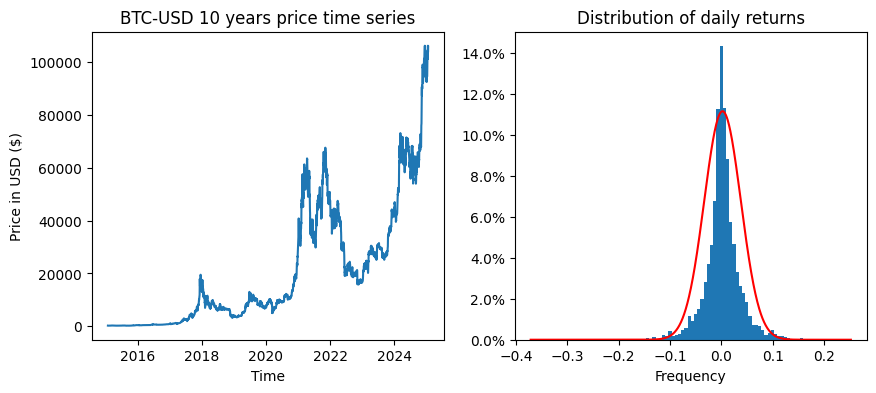

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4)) 

# Plot the first graph
ax1.plot(btc_close.index, btc_close.values)
ax1.set_title("BTC-USD 10 years price time series")
ax1.set_xlabel("Time")
ax1.set_ylabel("Price in USD ($)")

# Plot the second graph
len_btc_ret = len(btc_returns_10y)
weights = np.ones(len_btc_ret)/len_btc_ret*100

ax2.hist(btc_returns_10y, bins = 100, weights = weights )
ax2.set_title("Distribution of daily returns")
ax2.set_xlabel("Frequency")
ax2.yaxis.set_major_formatter(PercentFormatter(xmax=100)) 

"""
We overlap a gaussian distribution over the second graph to visually see how the distribution of returns
compares to a Gaussian.
"""
mu, std = norm.fit(btc_returns_10y)
x_axis_values = np.linspace(min(btc_returns_10y), max(btc_returns_10y), 1000)

pdf = norm.pdf(x_axis_values, mu, std)

ax2.plot(x_axis_values, pdf, "r-", label = "Gaussian Fit")

# Show the plot
plt.show()

In [12]:
# Let's also perform the Jarque-Bera test to check if returns are normally distributed

jb_stats, p_value = scipy.stats.jarque_bera(btc_returns_10y)

print(f"Jarque-Bera statistic: {jb_stats}")
print(f"p-value: {p_value}")

Jarque-Bera statistic: 8802.575432870904
p-value: 0.0


From Jarque-Bera's test there seems to be sufficient evidence that returns are not normally distributed.
To get a deeper insight, let's look at the skewnees and at the kurtosis of the data.

In [13]:
# Calculate skewness
skewness_value = scipy.stats.skew(btc_returns_10y)

# Calculate kurtosis (Fisher's definition)
kurtosis_value = scipy.stats.kurtosis(btc_returns_10y) 

print(f"Skewness: {skewness_value}")
print(f"Kurtosis: {kurtosis_value}")

Skewness: -0.09037959074806375
Kurtosis: 7.602614068768668


While the distribution seems to be centered, like the Gaussian distribution, it's evident that the tails are fatter than the normal distribution.

### Downside Analysis: Drawdown, Semideviation, VaR, CVar

In [14]:
# We defined a welath index with a starting capital of 1000 euros
wealth_index_btc = 1000*(1+btc_returns_10y).cumprod()
previous_peaks_btc = wealth_index_btc.cummax()

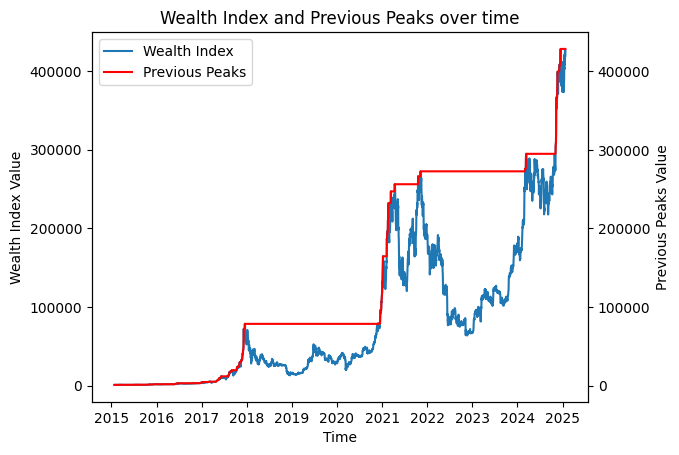

In [15]:
fig, ax = plt.subplots()

# First of all, we create a plot with a secondary y-axis
ax.plot(wealth_index_btc, label="Wealth Index") 
ax2 = ax.twinx() 
ax2.plot(previous_peaks_btc, color="r", label="Previous Peaks") 

# We set the labels for our plot
ax.set_xlabel("Time")
ax.set_ylabel("Wealth Index Value")
ax2.set_ylabel("Previous Peaks Value")
plt.title("Wealth Index and Previous Peaks over time")

# We unite the two legends into one
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc='upper left') 

plt.show()

<Axes: xlabel='Date'>

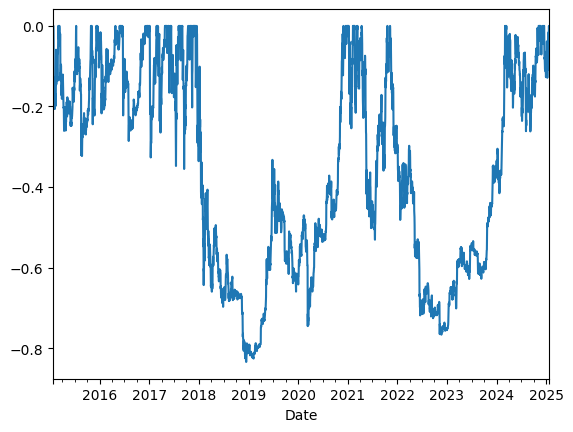

In [16]:
# We plot the drawdowns for the wealth index over time
drawdown_btc = (wealth_index_btc - previous_peaks_btc)/previous_peaks_btc
drawdown_btc.plot()

In [17]:
# Let's identify the maximum drawdown, and let's index when it happened

print(f"The maximum drawdown was: {-round(drawdown_btc.min(),2)}, which happened on {drawdown_btc.idxmin().strftime('%Y-%m-%d')}")

The maximum drawdown was: 0.83, which happened on 2018-12-15


In [18]:
# Now, let's calculate the semideviation of Bitcoin's returns by using a Boolean mask

print("Bitcoin's semideviation (for daily returns) is:", round(np.std(btc_returns_10y[btc_returns_10y<0],ddof=0),2))

Bitcoin's semideviation (for daily returns) is: 0.03


In [19]:
# Let's identify the daily VaR using the Historical Simulation Method

# We define the confidence level
alpha = 0.05

# We calculate the Historical VaR (daily frequency)
historical_var = np.quantile(btc_returns_10y.sort_values(), q= alpha)

# Let's assume a portfolio value of 1000 USD all invested in BTC-USD to estimate the VaR in monetary terms
portfolio_value = 1000

# We calculate the VaR in monetary terms
var_monetary_hist = portfolio_value * historical_var 

print("The daily VaR in monetary terms, based on historical values is:", -round(var_monetary_hist,2))


The daily VaR in monetary terms, based on historical values is: 54.42


In [20]:
# Now, let's try a different approach: let's calculate the VaR with bootstrap

# Confidence Level
alpha = 0.05
# Wealth/Portfolio Value
portfolio_value = 1000

num_boostraps = 10000

var_estimates = np.zeros(num_boostraps)

for i in range(num_boostraps):
    # Resample with replacement
    bootstrap_sample = np.random.choice(btc_returns_10y, size = round(len(btc_returns_10y)/2), replace= True)
    var_estimates[i]=np.quantile(bootstrap_sample, alpha)

var_monetary = portfolio_value*var_estimates

print(f"Mean Bootstrap VaR: {-np.mean(var_monetary):.2f}") 
print(f"VaR at {(1-alpha)*100}% confidence level: {-np.quantile(var_monetary, (1-alpha)):.2f}") 

Mean Bootstrap VaR: 54.38
VaR at 95.0% confidence level: 49.92


In [21]:
# Now, let's calculate the CVar based on the VaR

beyond_var_mask = btc_returns_10y*1000 <= var_monetary_hist
print("The CVaR in wealth terms is:", -round(btc_returns_10y[beyond_var_mask].mean()*1000,2))

The CVaR in wealth terms is: 83.18


# Part 2: Comparative Analysis (Monthly Data)

In [22]:
class Analyzer:
    """
    We write this class containing functions to analyze our data.

    It takes as the input the time series of returns of an asset and allows
    us to compute different kinds of statistics.
    """

    def __init__(self, returns):
        self.returns = returns
    
    def moments(self):
        mean = np.mean(self.returns)
        stdev = np.std(self.returns)
        skew = scipy.stats.skew(self.returns)
        kurtosis = scipy.stats.kurtosis(self.returns)

        moments_dict = {"Mean": mean, "Standard Deviation": stdev, "Skewness":skew, "Kurtosis":kurtosis}

        return moments_dict
    
    def isnormal(self, alpha = 0.05):
        jb_stats, p_value = scipy.stats.jarque_bera(self.returns)

        if p_value < alpha:
            return 0
        else:
            return 1
    
    def risk_stats(self, alpha = 0.05, wealth = 1000):
        wealth_index = wealth*(1+self.returns).cumprod()
        previous_peaks = wealth_index.cummax()
        
        drawdown = (wealth_index - previous_peaks)/previous_peaks
        max_drawdown = -round(drawdown.min(),2)
        max_drawdown_date = drawdown.idxmin().strftime('%Y-%m-%d')

        semideviation = round(np.std(self.returns[self.returns<0]),2)

        historical_var = wealth*np.quantile(self.returns.sort_values(), q = alpha)

        beyond_var_mask = self.returns*wealth <= historical_var
        cvar = self.returns[beyond_var_mask].mean()*wealth
        
        risk_stats_dict = {"Max Drawdown": max_drawdown,
                           "Max Drawdown Date": max_drawdown_date,
                           "Semideviation": semideviation,
                           "Historical VaR": historical_var,
                           "CVaR": cvar}
        
        return risk_stats_dict  
    
    def annualized_vol(self, periods_per_year):
        return np.std(self.returns)*(periods_per_year**0.05)
    
    def annualized_rets(self, periods_per_year, rf_rate = 0):
        rf_per_period = ((1+rf_rate)**(1/periods_per_year))-1
        excess_returns = self.returns-rf_per_period
        compounded_growth = (1+excess_returns).prod()
        
        n_periods = self.returns.shape[0]
        
        return (compounded_growth**(periods_per_year/n_periods))-1
    
    def sharpe_ratio(self, riskfree_rate, periods):       
        ann_excess_ret = self.annualized_rets(periods_per_year= periods, rf_rate= riskfree_rate)
        ann_vol = self.annualized_vol(periods)
        
        return ann_excess_ret/ann_vol

In [23]:
%%capture
ticker_btc = yf.Ticker("BTC-USD")
ticker_doge = yf.Ticker("DOGE-USD")
ticker_eth = yf.Ticker("ETH-USD")
tickers_stocks = yf.Tickers("AAPL MSFT AMZN GOOG TSLA NVDA BRK-B JPM JNJ PG NXPI HII MKTX DOC STM KO PEP WMT")

btc_hist = ticker_btc.history("8y").resample("M").last()

doge_hist = ticker_doge.history("8y").resample("M").last()

eth_hist = ticker_eth.history("8y").resample("M").last()

stocks_hist = tickers_stocks.history("8y").resample("M").last()
stocks_hist = stocks_hist.filter(regex="Close")
stocks_hist.columns = ["AAPL", "AMZN", "BRK-B", "GOOG", "JNJ", "JPM", "MSFT", "NVDA", "PG", "TSLA", "NXPI", "HII", "MKTX", "DOC", "STM", "KO", "PEP", "WMT"]
stocks_hist.index = stocks_hist.index.tz_localize('UTC')

In [24]:
assets_dict = {}

assets_dict["BTC"] = btc_hist["Close"]
assets_dict["DOGE"] = doge_hist["Close"]
assets_dict["ETH"] = eth_hist["Close"]

for i in stocks_hist.columns:
    assets_dict[i] = stocks_hist[i]

In [25]:
data = {}

for j in assets_dict.keys():
    asset = Analyzer(assets_dict[j].pct_change().dropna())

    stats_dict = {
        "Mean": asset.moments()["Mean"],
        "Standard Deviation": asset.moments()["Standard Deviation"],
        "Skewness": asset.moments()["Skewness"],
        "Kurtosis": asset.moments()["Kurtosis"],
        "Normality": asset.isnormal(),
        "Max Drawdown": asset.risk_stats()["Max Drawdown"],
        "Max Drawdown Date": asset.risk_stats()["Max Drawdown Date"],
        "Semideviation": asset.risk_stats()["Semideviation"],
        "Historical VaR": asset.risk_stats()["Historical VaR"],
        "CVaR": asset.risk_stats()["CVaR"],
        "Annualized Volatility": asset.annualized_vol(12),
        "Annualized Returns": asset.annualized_rets(12),
        "Sharpe Ratio": asset.sharpe_ratio(periods= 12, riskfree_rate = 0.03)
    }

    data[j] = stats_dict

In [26]:
comparative_stats = pd.DataFrame(data)

In [27]:
comparative_stats

,BTC,DOGE,ETH,AAPL,AMZN,BRK-B,GOOG,JNJ,JPM,MSFT,...,PG,TSLA,NXPI,HII,MKTX,DOC,STM,KO,PEP,WMT
Mean,0.073838,0.22177,0.060691,0.025292,0.022168,0.0122,0.003066,0.01947,0.005439,0.006137,...,0.007912,0.007964,0.022979,0.052122,0.01398,0.007184,0.009919,0.013735,0.050524,0.018161
Standard Deviation,0.228425,1.037465,0.281737,0.082642,0.088365,0.053291,0.074531,0.069369,0.080041,0.047617,...,0.047431,0.104302,0.057847,0.139576,0.097923,0.044705,0.048329,0.112673,0.192221,0.054278
Skewness,0.509548,4.830511,0.539576,-0.079969,0.192359,-0.14789,-0.306389,-0.265819,-0.617022,-0.035371,...,-0.797545,0.434524,0.009678,-0.099276,0.024888,0.070635,0.005678,0.438318,0.868476,-0.426469
Kurtosis,-0.063691,25.114822,-0.131044,-0.564478,0.984968,-0.327865,0.029515,-0.177936,1.23592,0.03203,...,1.403132,0.89079,-0.222283,0.020474,-0.017245,-0.260618,-0.351662,0.039959,1.029282,0.746915
Normality,1,0,1,1,1,1,1,1,0,1,...,0,0,1,1,1,1,1,1,0,1
Max Drawdown,0.76,0.82,0.9,0.3,0.52,0.24,0.54,0.4,0.45,0.16,...,0.24,0.64,0.31,0.63,0.41,0.18,0.21,0.53,0.68,0.22
Max Drawdown Date,2019-01-31,2022-08-31,2019-01-31,2018-12-31,2022-12-31,2022-09-30,2023-10-31,2022-12-31,2020-09-30,2024-04-30,...,2020-03-31,2024-05-31,2022-10-31,2022-09-30,2018-12-31,2025-01-31,2022-09-30,2024-12-31,2022-12-31,2018-05-31
Semideviation,0.1,0.12,0.12,0.04,0.05,0.03,0.05,0.04,0.06,0.03,...,0.04,0.06,0.03,0.08,0.06,0.03,0.03,0.06,0.08,0.04
Historical VaR,-257.955076,-346.391038,-332.93118,-115.200768,-109.303843,-69.552288,-114.096902,-98.514278,-119.646408,-70.705889,...,-84.453179,-147.323644,-69.200024,-189.861827,-124.063404,-71.560897,-78.960593,-156.92398,-209.883222,-59.872152
CVaR,-340.533989,-412.20102,-430.722157,-133.071601,-159.484022,-100.949521,-153.626105,-130.748396,-180.996889,-90.467195,...,-111.20811,-196.037191,-88.627295,-248.074924,-182.769717,-82.636103,-86.914017,-195.915104,-255.532191,-102.862825


### Efficient Frontier

In [28]:
def portfolio_volatility(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

def portfolio_return(weights, mean_returns):
    return np.sum(mean_returns * weights)

def efficient_return(mean_returns, cov_matrix, target_return):
    num_assets = len(mean_returns)
    args = (cov_matrix)
    def portfolio_return_constraint(weights):
        return portfolio_return(weights, mean_returns) - target_return
    constraints = (
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
        {'type': 'eq', 'fun': portfolio_return_constraint}
    )
    bounds = tuple((0, 1) for i in range(num_assets))
    result = minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args, 
                      method='SLSQP', bounds=bounds, constraints=constraints)
    return result

def minimize_volatility(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1}) 
    bounds = tuple((0, 1) for j in range(num_assets)) 
    result = minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args, 
                      method='SLSQP', bounds=bounds, constraints=constraints)
    return result

In [29]:
expected_returns = comparative_stats.iloc[11]

assets_df = pd.DataFrame(assets_dict)
assets_df = assets_df.pct_change().dropna()
cov_matrix = assets_df.cov()

In [30]:
min_vol_weights = minimize_volatility(expected_returns, cov_matrix)['x']
min_vol_port_return = portfolio_return(min_vol_weights, expected_returns)
min_vol_port_std = portfolio_volatility(min_vol_weights, cov_matrix)

target_returns = np.linspace(min_vol_port_return, max(expected_returns), 30)

NameError: name 'minimize' is not defined

In [139]:
efficient_frontier = [efficient_return(expected_returns, cov_matrix, target_return)['x'] 
                     for target_return in target_returns]

efficient_frontier_returns = [portfolio_return(w, expected_returns) for w in efficient_frontier]
efficient_frontier_volatility = [portfolio_volatility(w, cov_matrix) 
                                 for w in efficient_frontier]

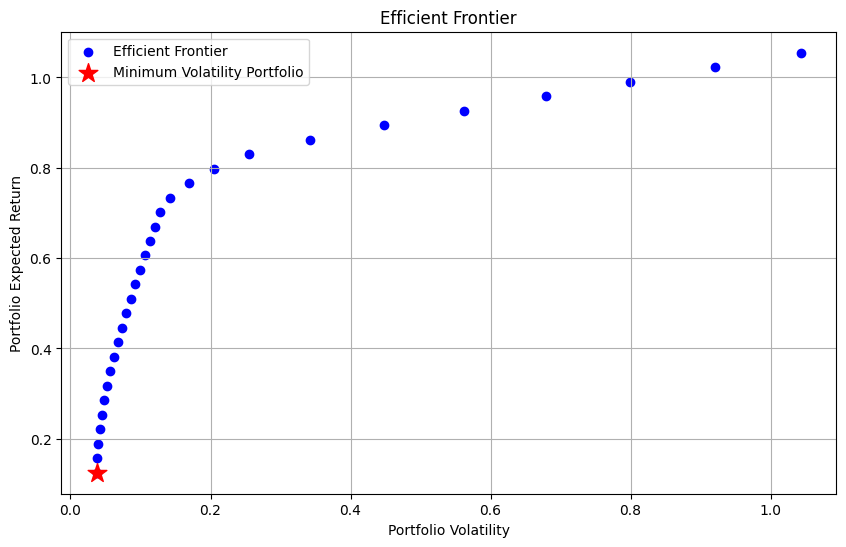

In [160]:
plt.figure(figsize=(10, 6))
plt.scatter(efficient_frontier_volatility, efficient_frontier_returns, marker='o', color='blue', label='Efficient Frontier')
plt.scatter(min_vol_port_std, min_vol_port_return, color='red', marker='*', s=200, label='Minimum Volatility Portfolio')
plt.xlabel('Portfolio Volatility')
plt.ylabel('Portfolio Expected Return')
plt.title('Efficient Frontier')
plt.legend()
plt.grid(True)
plt.show()

In [141]:
print(f"The volatility and the returns of the minimimum volatility portfolio are the following: \n Volatility: {round(min_vol_port_std,2)} \n Returns: {round(min_vol_port_return,2)}")

The volatility and the returns of the minimimum volatility portfolio are the following: 
 Volatility: 0.04 
 Returns: 0.12


### Time and volatility comparison between BTC and other Tickers

In [33]:
from scipy.interpolate import make_interp_spline

# Function that plot a gaussian fit comparison of btc and asset_to_comp 
def plot_return_distributions(btc, asset_to_comp, asset_name, ax):

    #probability density function
    btc_returns = np.diff(np.log(btc))
    btc_mu, btc_std = norm.fit(btc_returns)
    x_btc = np.linspace(-0.3, 0.3, 100)
    pdf = norm.pdf(x_btc, btc_mu, btc_std)

    #data for plotting
    asset_returns = np.diff(np.log(asset_to_comp)) 
    asset_mu, asset_std = norm.fit(asset_returns)
    x_asset = np.linspace(-0.3, 0.3, 100)
    pdf_asset = norm.pdf(x_asset, asset_mu, asset_std)

    #plot
    ax.plot(x_btc, pdf, 'g-', label='Bitcoin')
    ax.plot(x_asset, pdf_asset, 'r-', label=f"{asset_name}")
    ax.set_title(f"Annual Return Distributions")
    ax.set_xlabel("Return")
    ax.set_ylabel("Density")
    ax.set_xlim(-0.3, 0.3)
    ax.legend()

def plot_log_time_series(btc, asset_to_comp, asset_name, ax):
    # Time series on log scale - last 10 yrs
    ax.plot(np.linspace(0, 10, len(btc)), btc/ btc[0], 'g-',  label="Bitcoin")
    ax.plot(np.linspace(0, 10, len(asset_to_comp)), asset_to_comp / asset_to_comp[0], 'r-', label=asset_name)
    ax.set_title(f"Time series (Log Scale)")
    ax.set_xlabel("Year")
    ax.set_ylabel("Price")
    ax.set_yscale("log")
    ax.legend()

def plot_correlation(btc, asset_to_comp, asset_name, ax):

    # collect data from last year    
    btc_returns = np.diff(btc[-365:-1]) / btc[-365:-2]
    asset_returns = np.diff(asset_to_comp[-365:-1]) / asset_to_comp[-365:-2]
    
    #calc difference in % returns
    return_diff = btc_returns - asset_returns
    
    #average pct differnce (on 28 days) for 12 months
    month_diff = []
    sum_val = 0
    for i, data in enumerate(return_diff):
        sum_val += data
        if (i + 1) % 28 == 0 or i == len(return_diff) - 1:
            month_diff.append(sum_val)
            sum_val = 0
    
    months = np.arange(len(month_diff))
    
    #cubic interploation to smooth the curve
    spline = make_interp_spline(months, month_diff, k=3)
    smooth_months = np.linspace(months.min(), months.max(), 300)
    smooth_diff = spline(smooth_months)
    
    # green if BTC outperformed asset, red elsewhere
    colors = ['g' if val >= 0 else 'r' for val in smooth_diff]
    
    #plot data
    for i in range(len(smooth_months) - 1):
        ax.plot(smooth_months[i:i+2], smooth_diff[i:i+2], color=colors[i], linewidth=2)
    
    ax.fill_between(smooth_months, smooth_diff, 0, where=(smooth_diff >= 0), color='g', alpha=0.3)
    ax.fill_between(smooth_months, smooth_diff, 0, where=(smooth_diff < 0), color='r', alpha=0.3)
    
    ax.set_title(f"Performance difference within last year")
    ax.set_ylabel(f"% Btc - % {asset_name}")
    ax.set_xlabel("Month")

def plot_lin_time_series(btc, asset_to_comp, asset_name, ax):
    # Time series on log scale
    p1 = btc[-350:-1]
    p2 = asset_to_comp[-350:-1]
    ax.plot(np.linspace(0, 12, len(p1)), p1/ p1[0], 'g-', label="Bitcoin")
    ax.plot(np.linspace(0, 12, len(p2)), p2 / p2[0], 'r-' , label=asset_name)
    ax.set_title(f"Time series (Lin Scale): Bitcoin vs {asset_name}")
    ax.set_xlabel("Month")
    ax.set_ylabel("Price Relative to Year Start")
    ax.legend()


def compare_with_btc(btc_prices, asset_prices, asset_name):

    fig, axs = plt.subplots(4, 1, figsize=(10, 10))

    plot_log_time_series(btc_prices, asset_prices, asset_name, axs[0])

    plot_return_distributions(btc_prices, asset_prices, asset_name, axs[1])

    plot_correlation(btc_prices, asset_prices, asset_name, axs[2])

    plot_lin_time_series(btc_prices, asset_prices, asset_name, axs[3])

    plt.tight_layout()
    plt.show()

btc = yf.Ticker("BTC-USD")
btc_hist = btc.history(period="10y")
btc_prices = btc_hist["Close"].values

def fetch(asset_ticker, period="10y"):
    asset = yf.Ticker(asset_ticker)
    asset_hist = asset.history(period=period)
    
    asset_prices = asset_hist["Close"].values
    return asset_prices

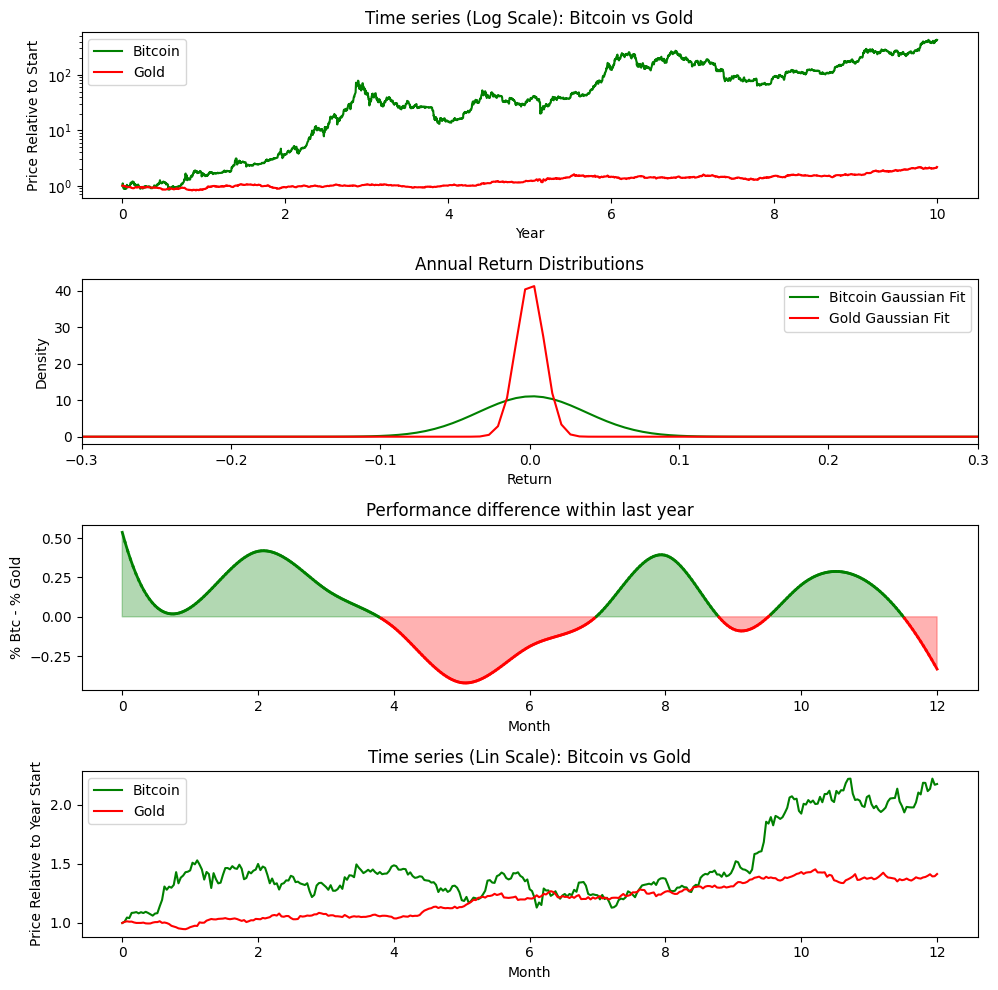

In [34]:
compare_with_btc(btc_prices=btc_prices, asset_prices= fetch("GC=F"), asset_name="Gold")

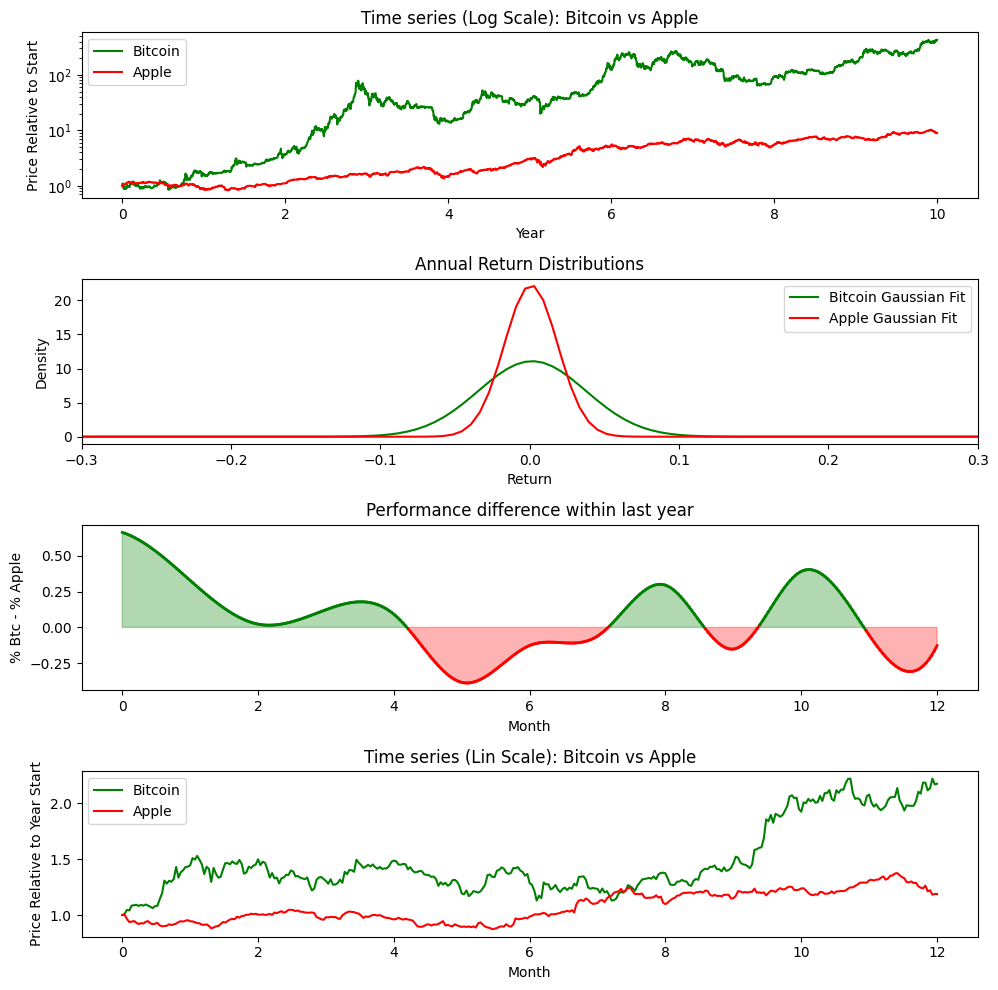

In [35]:
compare_with_btc(btc_prices=btc_prices, asset_prices= fetch("AAPL"), asset_name="Apple")

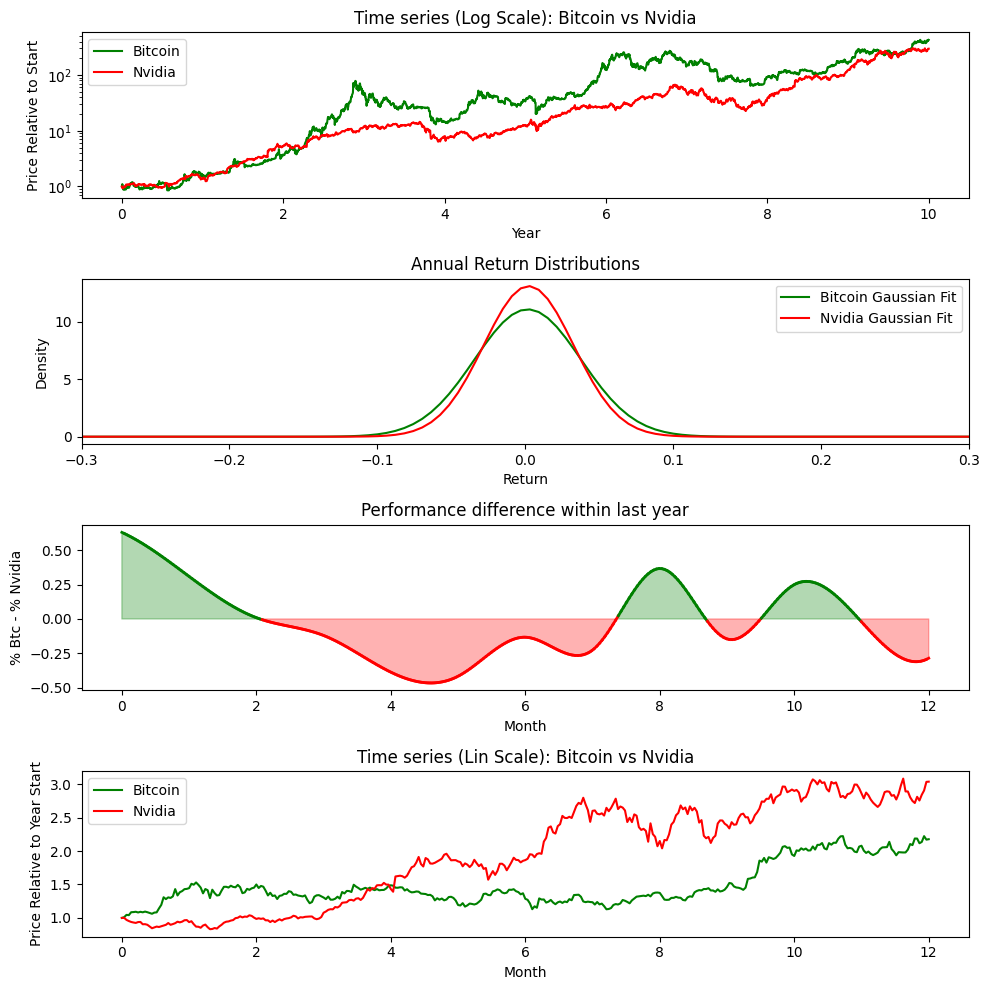

In [36]:
compare_with_btc(btc_prices=btc_prices, asset_prices= fetch("NVDA"), asset_name="Nvidia")

# Bitcoin Price Forecasting with XGBoost